# 1. Setup

In [1]:
import plotly.express as px
from scipy.optimize import curve_fit

from utils import *

# 2. Prepare data for Indianapolis

In [2]:
# inroot = Path('../../access/data')
# outroot = mkdir('../data/access')

## 2.1. Urban areas

In [3]:
def get_urban_areas(overwrite=False):
    outpath = DATA / 'access/urban_areas_2020.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    url = 'https://www2.census.gov/geo/docs/reference/ua/2020_UA_BLOCKS.txt'
    df = pd.read_csv(url, sep='|', encoding_errors='replace')
    df = df.rename(columns=str.lower)
    df.geoid = df.geoid.astype(str).str[:12]
    df = df.rename(columns={'2020_ua_name': 'urba'})
    df = df.groupby(['geoid', 'urba']).size().rename('n').reset_index()
    df = df.sort_values('n', ascending=0).drop_duplicates('geoid')
    df = df[['geoid', 'urba']].reset_index(drop=1)
    df.to_parquet(mkfile(outpath))
    return df

ua = get_urban_areas(overwrite=0).disp() # 8s

200,858 rows x 2 cols; Memory: 27.9 MiB


geoid             urba
       <object>         <object>
0  120559614012  Lake Placid, FL

## 2.2. Zones

In [4]:
def get_zones(msa, urban_areas=ua, inroot=inroot, overwrite=False):
    outpath = outroot / 'zones.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    df = gpd.read_parquet(inroot / 'zones/msa_2020.parquet', filters=[
        ('region', '==', msa), ('scale', '==', 'bg')])
    df['cnty_id'] = df.geoid.str[:5]
    cnty = pd.read_parquet(inroot / 'zones/us/county_2020.parquet', columns=[
        'geoid', 'name']).rename(columns=D(geoid='cnty_id', name='county'))
    df = df.merge(cnty, on='cnty_id')
    # df = df[~df.county.isin(['Brown', 'Tipton', 'Madison'])]
    popu = pd.read_parquet(inroot / 'ses/acs_2021.parquet', filters=[
        ('scale', '==', 'bg')], columns=['geoid', 'popu'])
    df = df.merge(popu, 'left', on='geoid').to_crs(CRS_M)
    df['pop_density'] = df['popu'].fillna(0) / (df['aland'] * SQM2SQMI)
    df = df.merge(urban_areas, 'left', on='geoid')
    df['urbanity'] = df.urba.isna().map({True: 'Rural', False: 'Urban'})
    df = df[['geoid', 'county', 'popu', 'pop_density', 'geometry']]
    df.to_parquet(mkfile(outpath))
    return df

zones = get_zones('indianapolis', overwrite=1).disp()

1,432 rows x 5 cols; Memory: 0.2 MiB; <Projected CRS: EPSG:3857>


geoid    county       popu pop_density  \
       <object>  <object>  <float64>   <float64>   
0  180118101001     Boone     1347.0     36.7519   

                                            geometry  
                                          <geometry>  
0  POLYGON ((-9638231.869211 4878118.620342, -963...

## 2.3. SES

In [5]:
def get_ses(zones=zones):
    ses_cols = 'p_senior p_poc m_income p_unemploy p_renter m_hhperveh'.split()
    df = pd.read_parquet(outroot / 'acs_2021.parquet')
    df = zones[['geoid']].merge(df)
    df['sedi'] = df[ses_cols].apply(lambda x: x.fillna(0).rank(pct=1)).mean(1)
    df['ses'] = pd.cut(df.sedi, [-1, 0.33, 0.67, 1.1], labels=['High', 'Mid', 'Low'])
    df = df[['geoid', 'sedi', 'ses']]
    return df

ses = get_ses().disp()

1,426 rows x 3 cols; Memory: 0.1 MiB


geoid       sedi         ses
       <object>  <float64>  <category>
0  180118101001   0.338476         Mid

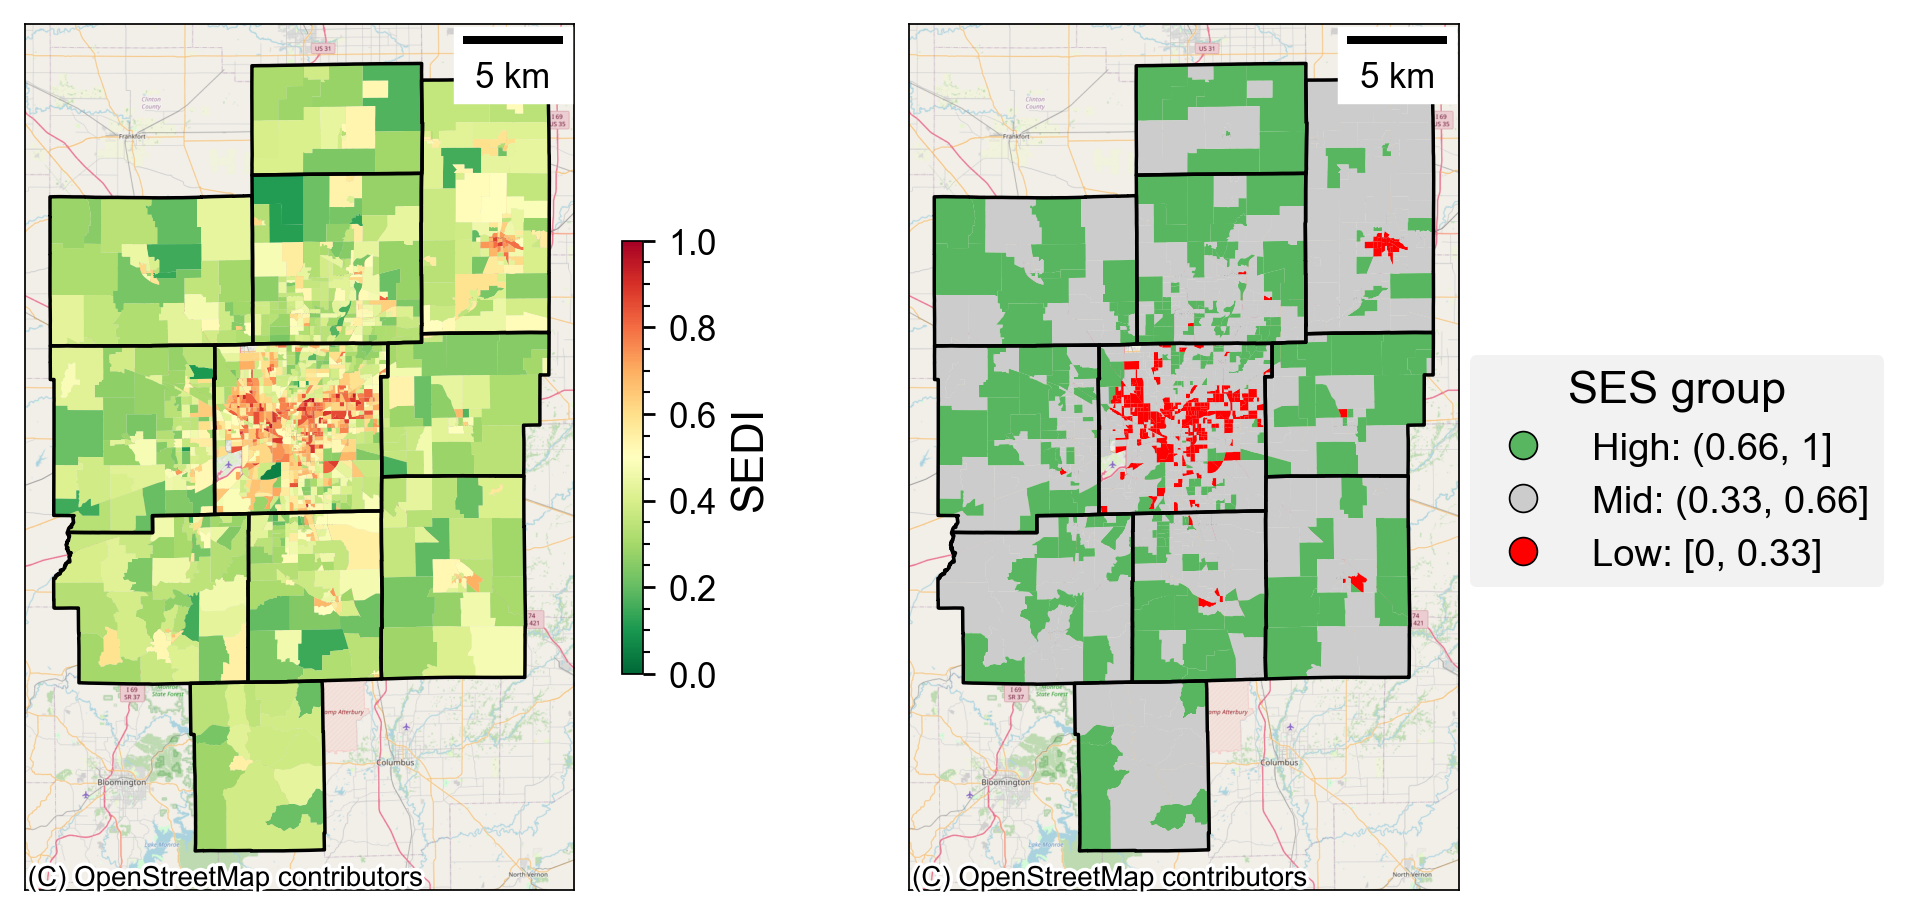

In [6]:
def fig_ses_indy(ses=ses, zones=zones, dpi=150):
    colors = D(High='#57B65F', Mid='#ccc', Low='r')
    ses = zones.merge(ses.assign(color=ses.ses.map(colors)))
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), dpi=dpi,
                                 gridspec_kw=D(width_ratios=[1, 0.8]))
    ses.plot(ax=ax1, column='sedi', cmap='RdYlGn_r', vmin=0, vmax=1,
             legend=True, legend_kwds=D(shrink=0.5, label='SEDI'))
    ses.plot(ax=ax2, color=ses.color)
    ses_labels = ['High: (0.66, 1]', 'Mid: (0.33, 0.66]', 'Low: [0, 0.33]']
    ax2.legend(loc=(1.02, 0.35), title='SES group', handles=[
        mpl.lines.Line2D([0], [0], label=x, color='none', marker='o',
                         markerfacecolor=c, markersize=8, markeredgewidth=0.5)
        for x, c in zip(ses_labels, colors.values())])
    for ax in (ax1, ax2):
        zones.dissolve('county').plot(ax=ax, fc='none', ec='k')
        basemap(ax)
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05)

fig_ses_indy(dpi=250)

## 2.4. Opportunities

In [7]:
opport = (
    pd.read_parquet(inroot / 'opport/opportunities.parquet')
    .merge(zones['geoid']).assign(purpose=lambda df: df.kind.map(
        D(total='Work', overall='Non-work')))
    [['geoid', 'purpose', 'opport']].dropna()
).disp()

2,800 rows x 3 cols; Memory: 0.4 MiB


geoid   purpose   opport
       <object>  <object>  <int32>
0  180118101001      Work      183

## 2.5. Travel times

In [8]:
tt = (
    pd.read_parquet('../../equity_atlas/data/access/travel_times.parquet')
    .merge(zones['geoid'].rename('src'))
    .merge(zones['geoid'].rename('trg'))
    .astype(D(src=CAT, trg=CAT))
    .query('time <= 90')
).disp()

3,000,956 rows x 5 cols; Memory: 51.8 MiB


src           trg       scale        mode       time
     <category>    <category>  <category>  <category>  <float32>
0  181095107012  180816112003          BG       Drive  38.650002

In [9]:
# sns.displot(tt, x='time', hue='mode', kind='kde', fill=True, palette=sns.color_palette('bright')[:4], height=3);

### 2.5.1. Impedance function params
Taken from the results of `2_select_factors.ipynb`.

In [10]:
params = Pdf([
    ('Overall', 'Overall', 0.054),
    ('Mode', 'Drive', 0.055),
    ('Mode', 'Transit', 0.020),
    ('Mode', 'Walk', 0.060),
    ('Mode', 'Bike', 0.046),
    ('Purpose', 'Work', 0.038),
    ('Purpose', 'Non-work', 0.058),
    ('SES', 'Low', 0.046),
    ('SES', 'Mid', 0.056),
    ('SES', 'High', 0.053),
], columns=['factor', 'level', 'beta']).disp()

10 rows x 3 cols; Memory: 0.0 MiB


factor     level       beta
   <object>  <object>  <float64>
0   Overall   Overall      0.054

## 2.6. Compute accessibility

In [11]:
def get_access_bg(opport=opport, tt=tt, ses=ses, params=params):
    beta0 = params.iloc[0].beta
    opp_poi = opport.query('purpose=="Non-work"')
    tt = tt.rename(columns=D(trg='geoid'))
    tt_drive = tt.query('mode=="Drive"')
    def f(df, factor, level):
        beta = params.query(f'factor=="{factor}" & level=="{level}"')
        df['general'] = df.opport * np.exp(-beta0 * df.time)
        df['case'] = df.opport * np.exp(-beta.iloc[0].beta * df.time)
        df = df.groupby('src')[['general', 'case']].sum().reset_index()
        return df.assign(factor=factor, level=level)
    res = []
    for mode, df in tt.groupby('mode'):
        res.append(f(df.merge(opp_poi), 'Mode', mode))
    for purp, df in opport.groupby('purpose'):
        res.append(f(tt_drive.merge(df), 'Purpose', purp))
    for ses_cat, df in ses.groupby('ses'):
        res.append(f(opp_poi.merge(df).merge(tt_drive), 'SES', ses_cat))
    df = pd.concat(res).rename(columns=D(src='geoid'))
    df['pct_diff'] = (df.general / (df.case + 1e-6) - 1) * 100
    df.factor, df.level = ordered_factor(df.factor), ordered_factor(df.level)
    return df

xs_bg = get_access_bg().disp()
# x = get_access_bg(); x

12,888 rows x 6 cols; Memory: 0.6 MiB


geoid    general       case      factor       level   pct_diff
     <category>  <float64>  <float64>  <category>  <category>  <float64>
0  180118101001  37.300698  52.900542        Mode        Bike -29.489008

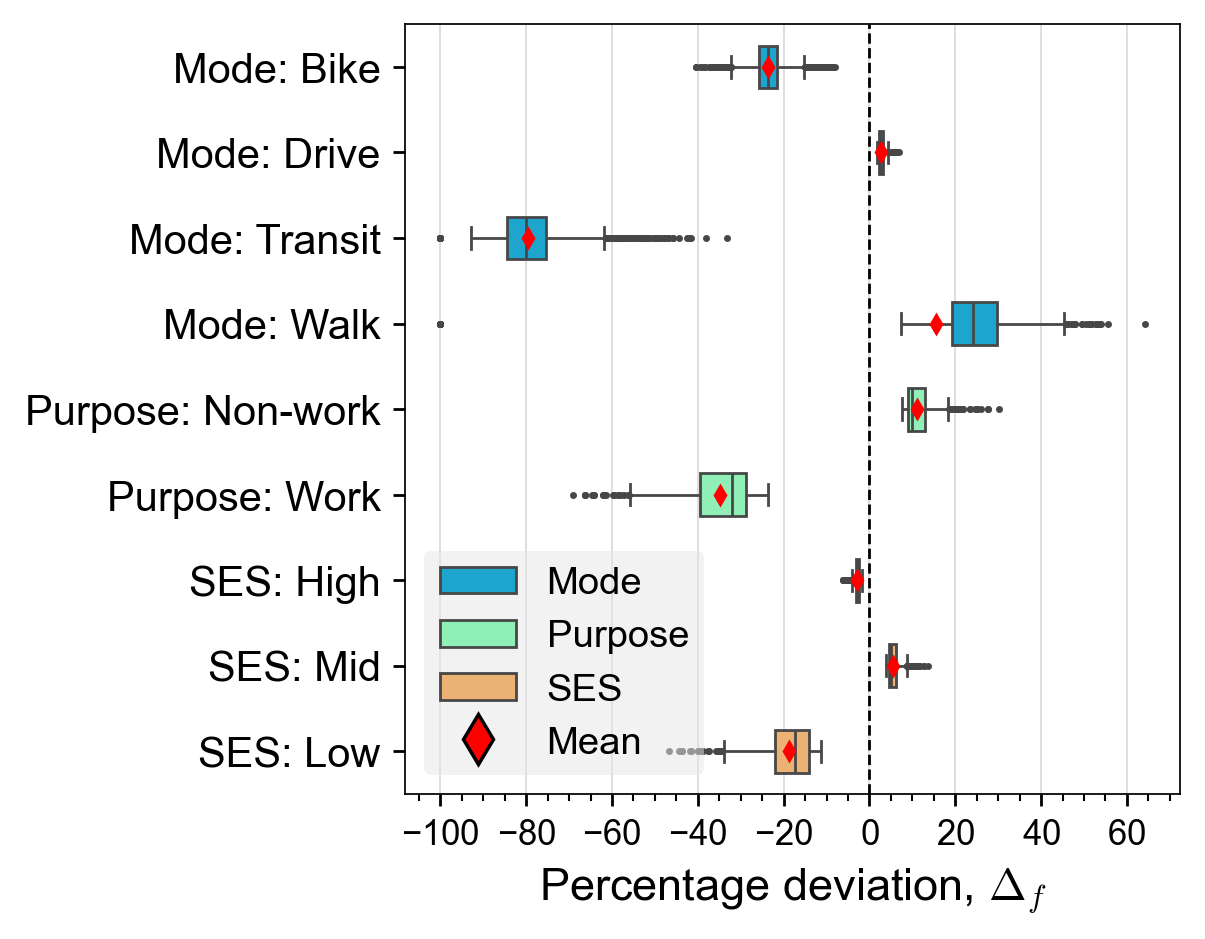

In [14]:
ax = pplot(size=(4, 4), ylim=(-100, 50), dpi=250, yminor=0)
sns.boxplot(xs_bg.assign(var=lambda df: df.factor.astype(str) + ': ' + df.level.astype(str)),
            x='pct_diff', y='var', ax=ax, linewidth=0.8,
            width=0.5, fliersize=1, hue='factor', palette='rainbow',
            showmeans=True, meanprops=D(marker='d', markerfacecolor='r',
                                        markersize=5, markeredgecolor='none'))
ax.yaxis.set_tick_params(labelsize=12)
ax.axvline(0, ls='--', color='k', lw=0.8)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.legend(handles=list(ax.legend().legend_handles) + [
    mpl.lines.Line2D([0], [0], color='none', label='Mean',
                     marker='d', markerfacecolor='r', markersize=10)
    ], title='', loc='lower left')
ax.set_ylabel(''); ax.set_xlabel('Percentage deviation, $\Delta_f$');

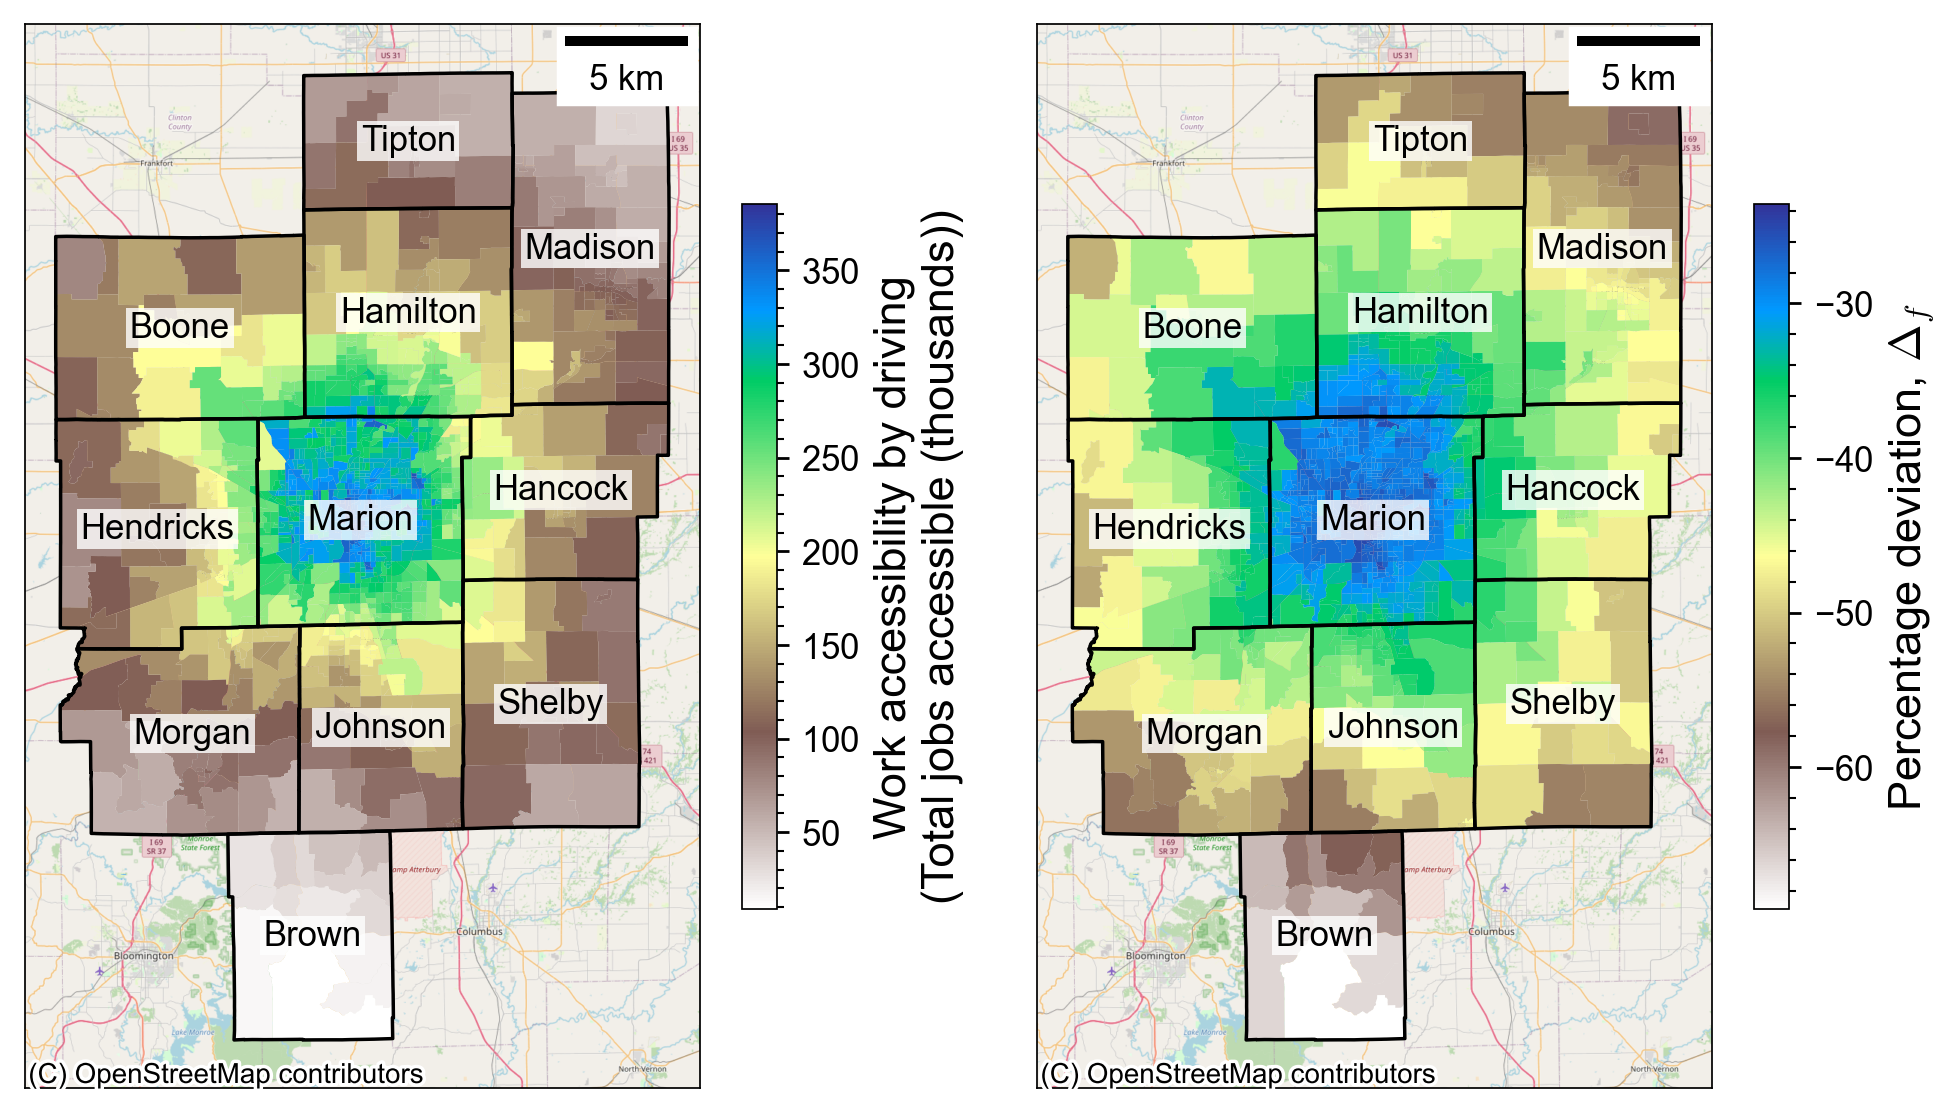

In [27]:
def fig_xs_delta_main(xs=xs_bg, zones=zones, dpi=150):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), dpi=dpi)
    df = xs.query('factor=="Purpose" & level=="Work"').copy()
    df['general'] /= 1000
    label = 'Work accessibility by driving\n(Total jobs accessible (thousands))'
    zones.merge(df).plot(ax=ax1, column='general', cmap='terrain_r',
                         legend=1, legend_kwds=D(shrink=0.6, label=label))
    label = 'Percentage deviation, $\Delta_f$'
    zones.merge(df).plot(ax=ax2, column='pct_diff', cmap='terrain_r',
                         legend=1, legend_kwds=D(shrink=0.6, label=label))
    cnty = zones.dissolve('county')
    for ax in [ax1, ax2]:
        cnty.plot(ax=ax, fc='none', ec='k', lw=1)
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
        basemap(ax)
        for _, r in cnty.iterrows():
            x, y = r.geometry.centroid.coords[0]
            ax.text(x, y, r.name, ha='center', va='center',
                    bbox=D(fc='w', alpha=0.8, pad=1, ec='none'))
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)

x = fig_xs_delta_main(dpi=250); x # 6s

  0%|          | 0/9 [00:00<?, ?it/s]

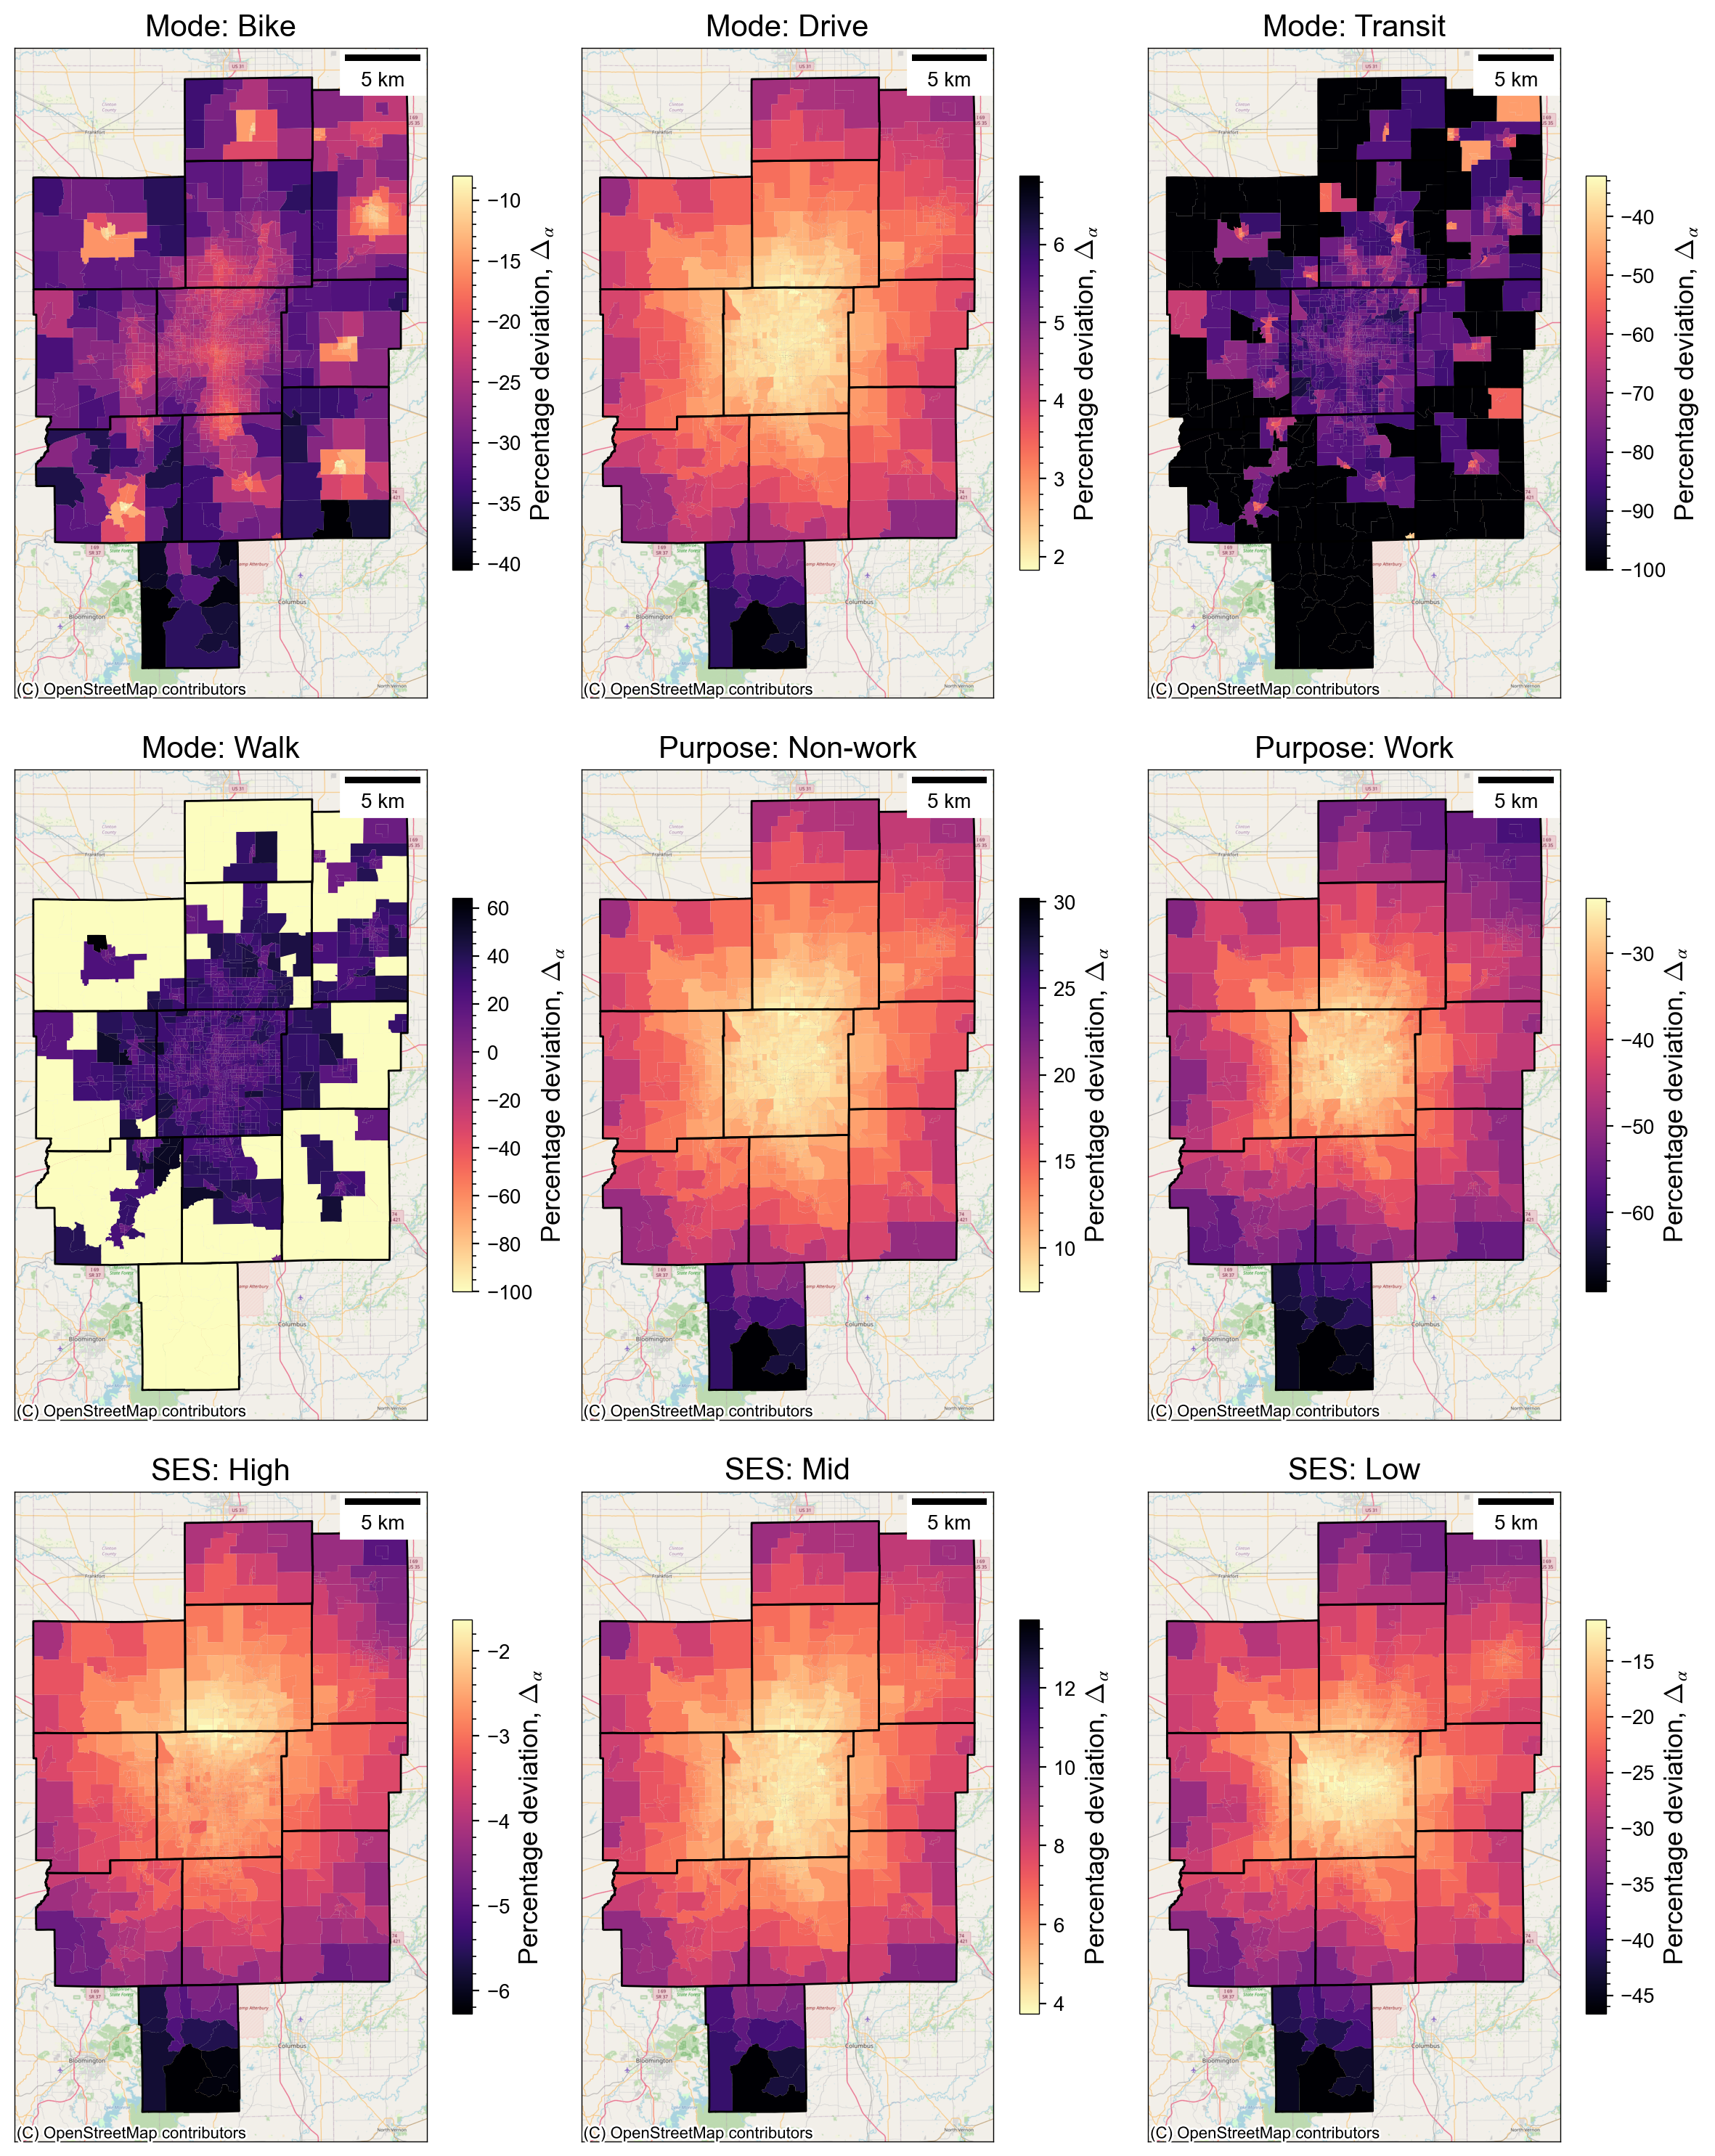

In [20]:
def fig_xs_delta_by_var(xs=xs_bg, zones=zones, dpi=100, cmap='magma'):
    _, axes = plt.subplots(3, 3, figsize=(12, 15), dpi=dpi)
    cnty = zones.dissolve('county')
    for i, (level, df) in enumerate(tqdm(xs.groupby('level'))):
        ax = pplot(axes.flatten()[i], title=f'{df.factor.iloc[0]}: {level}')
        cmap2 = cmap + ('_r' if df.pct_diff.mean() > 0 else '')
        zones.merge(df).plot(
            ax=ax, column='pct_diff', cmap=cmap2, legend=True, legend_kwds=D(
                shrink=0.6, label='Percentage deviation, $\Delta_α$'))
        cnty.plot(ax=ax, fc='none', ec='k', lw=1)
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
        basemap(ax)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

fig_xs_delta_by_var(dpi=200) # 24s